In [8]:
import pandas as pd

# Recarregar a base original para manter todas as colunas
df_original = pd.read_csv("historico_alugueis.csv")

# Preparar dados para clusterização, removendo ID e usando colunas relevantes
df_cluster_data = df_original[
    ['Valor do contrato do aluguel', 'Tempo de aluguel', 
     'Histórico de contratos anteriores', 'Pagamentos atrasados']
]

# Codificar variáveis categóricas
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()

df_cluster_data['Histórico de contratos anteriores'] = label_encoder.fit_transform(
    df_cluster_data['Histórico de contratos anteriores'].str.lower()
)
df_cluster_data['Pagamentos atrasados'] = label_encoder.fit_transform(
    df_cluster_data['Pagamentos atrasados'].str.lower()
)

# Função para converter valores monetários corretamente
def limpar_valor_monetario(valor):
    try:
        return float(valor.replace('R$', '').replace(',', '').strip())
    except:
        return None  # Retorna None em caso de erro

df_cluster_data['Valor do contrato do aluguel'] = df_original['Valor do contrato do aluguel'].apply(limpar_valor_monetario)

# Converter 'Tempo de aluguel' para tipo numérico (se necessário)
df_cluster_data['Tempo de aluguel'] = pd.to_numeric(df_cluster_data['Tempo de aluguel'], errors='coerce')

# Preencher valores ausentes com a média
df_cluster_data.fillna(df_cluster_data.mean(), inplace=True)

# Normalizar os dados
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster_data)

# Aplicar K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

# Adicionar a coluna 'cluster' ao dataframe original
df_original['cluster'] = clusters

# Verificar e converter colunas numéricas corretamente antes da agregação
df_original['Valor do contrato do aluguel'] = pd.to_numeric(
    df_original['Valor do contrato do aluguel'].apply(limpar_valor_monetario), errors='coerce'
)
df_original['Tempo de aluguel'] = pd.to_numeric(df_original['Tempo de aluguel'], errors='coerce')

# Análise dos clusters
cluster_summary = df_original.groupby('cluster').agg(
    valor_medio_aluguel=('Valor do contrato do aluguel', 'mean'),
    tempo_medio_aluguel=('Tempo de aluguel', 'mean'),
    #historico_medio_contratos=('Histórico de contratos anteriores', 'mean'),
    tipo_cliente_mais_comum=('Tipo do cliente', lambda x: x.mode().iloc[0] if not x.empty else None),
    quantidade=('ID do cliente', 'count')
).reset_index()

# Identificar o cluster mais valioso
cluster_valioso = cluster_summary.sort_values(
    ['valor_medio_aluguel', 'tempo_medio_aluguel'], ascending=False
).iloc[0]

# Filtrar clientes do cluster mais valioso
clientes_valiosos = df_original[df_original['cluster'] == cluster_valioso['cluster']]

# Exibir resultados
print("Resumo dos Clusters:")
print(cluster_summary)

print("\nCluster mais valioso:")
print(cluster_valioso)

print("\nClientes mais valiosos (do cluster mais valioso):")
print(clientes_valiosos[
    ['ID do cliente', 'Valor do contrato do aluguel', 'Tempo de aluguel', 'Tipo do cliente']
])


Resumo dos Clusters:
   cluster  valor_medio_aluguel  tempo_medio_aluguel tipo_cliente_mais_comum  \
0        0         28056.571720             5.188370                     b2c   
1        1        113938.684585            17.797782                     B2B   
2        2         26106.331991             4.746805                     B2C   
3        3         17164.221911             3.277249                     B2c   

   quantidade  
0       14222  
1       21096  
2       15648  
3       53598  

Cluster mais valioso:
cluster                                1
valor_medio_aluguel        113938.684585
tempo_medio_aluguel            17.797782
tipo_cliente_mais_comum              B2B
quantidade                         21096
Name: 1, dtype: object

Clientes mais valiosos (do cluster mais valioso):
        ID do cliente  Valor do contrato do aluguel  Tempo de aluguel  \
5             78794.0                      160200.0              18.0   
9             48930.0                       83904.

C:\Users\sousa\AppData\Local\Temp\ipykernel_15596\1081960179.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_data['Histórico de contratos anteriores'] = label_encoder.fit_transform(
C:\Users\sousa\AppData\Local\Temp\ipykernel_15596\1081960179.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_data['Pagamentos atrasados'] = label_encoder.fit_transform(
C:\Users\sousa\AppData\Local\Temp\ipykernel_15596\1081960179.py:30: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [9]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.fit_predict(X))

np.float64(0.6160175565116061)

In [10]:
db_final = df_original.copy()

#retirnando linhas que contem todos os valores nulos e linhas duplicadas
db_final.dropna(how='all', inplace=True)
db_final = db_final.drop_duplicates()

# Apagando colunas que não serão utilizadas
# Passando por cada coluna para tratar ela da melhor forma
# Utilizando primeiro o display com unique para entender os valores unicos de cada coluna
# Em seguida realizando o tratamento de acordo com o que foi observado
db_final = db_final.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
db_final = db_final.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)

# Tratando a coluna 'ID do aluguel'
#db_final['ID do cliente'] = db_final['ID do cliente'].astype(int)

# Tratando a coluna 'tipo de carro alugado'

# Tratando a coluna 'Tempo de aluguel'
#db_final['Tempo de aluguel'] = db_final['Tempo de aluguel'].astype(int)

#Data de inicio
import re

# Function to convert months in Portuguese-English mix to standard format
# Modify the function to handle non-string (NaN) values safely

def convert_portuguese_date_format(date_str):
    if isinstance(date_str, str):
        # Mapping English month names to their corresponding numbers
        months_mapping = {
            'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
            'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
            'november': '11', 'december': '12'
        }

        # Pattern to match the format '6 de january de 2022'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                return f'{day}/{month_num}/{year}'
    return date_str  # Return as is if it's not a match or not a string

db_final['Data de início do aluguel'] = db_final['Data de início do aluguel'].apply(convert_portuguese_date_format)
db_final['Data de início do aluguel'] = pd.to_datetime(db_final['Data de início do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Data final do aluguel'    
db_final['Data final do aluguel'] = db_final['Data final do aluguel'].apply(convert_portuguese_date_format)
db_final['Data final do aluguel'] = pd.to_datetime(db_final['Data final do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Valor do contrato do aluguel'
def clean_valor_do_contrato(value):
    if isinstance(value, str):
        value = value.lower()
        value = value.replace('r$', '').replace('.', '').replace(',', '.').strip()
    return float(value) if value else None

db_final['Valor do contrato do aluguel'] = db_final['Valor do contrato do aluguel'].apply(clean_valor_do_contrato)

#Tratando a coluna Idade do carro
#db_final['Idade do carro'] = db_final['Idade do carro'].astype(int)

# Tratando a coluna Satisfação do cliente
#db_final['Satisfação do cliente'] = db_final['Satisfação do cliente'].astype(int)

# Tratando Desconto aplicado no contrato
db_final['Desconto aplicado no contrato'] = db_final['Desconto aplicado no contrato'].apply(clean_valor_do_contrato)

# Criando coluna valor médio do carro por mês
db_final['Valor médio do carro por mês'] = db_final['Valor do contrato do aluguel'] / db_final['Tempo de aluguel']
                              


C:\Users\sousa\AppData\Local\Temp\ipykernel_15596\3075672846.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  db_final = db_final.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
C:\Users\sousa\AppData\Local\Temp\ipykernel_15596\3075672846.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  db_final = db_final.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)


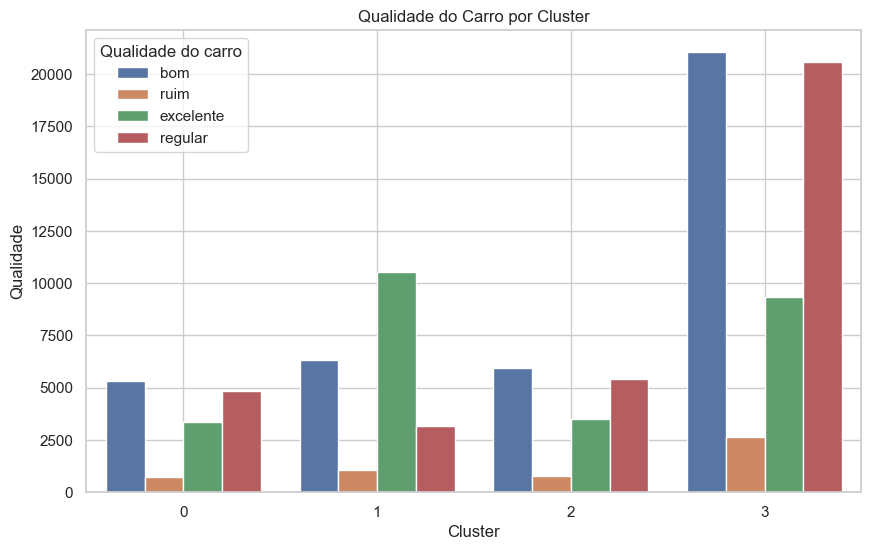

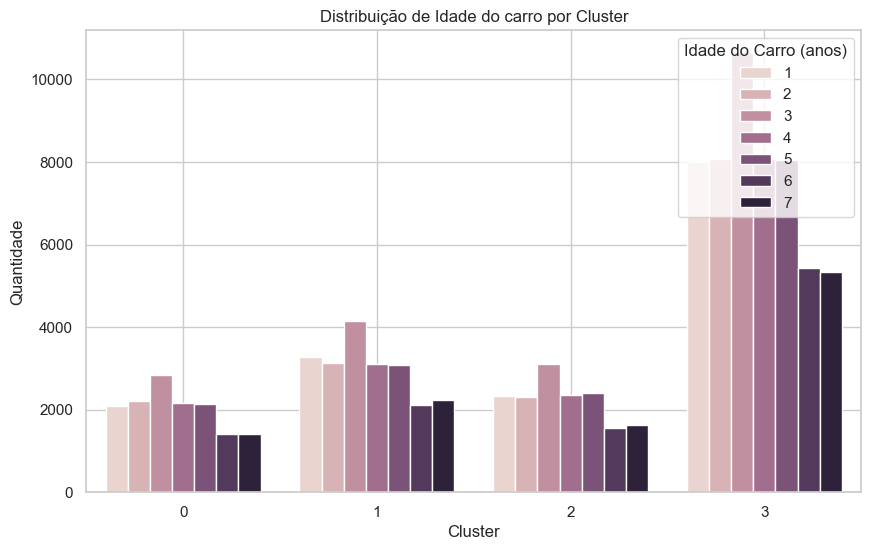

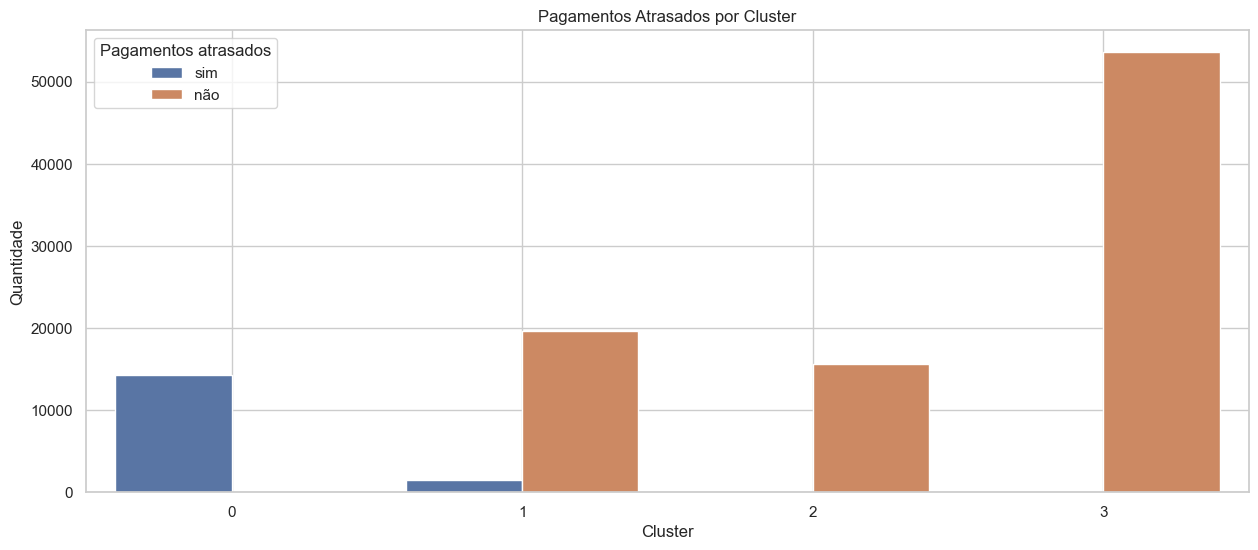

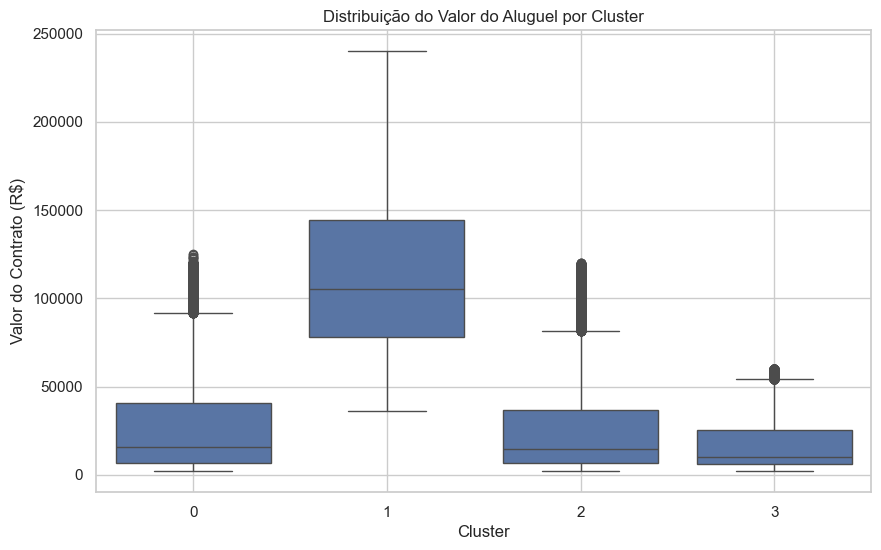

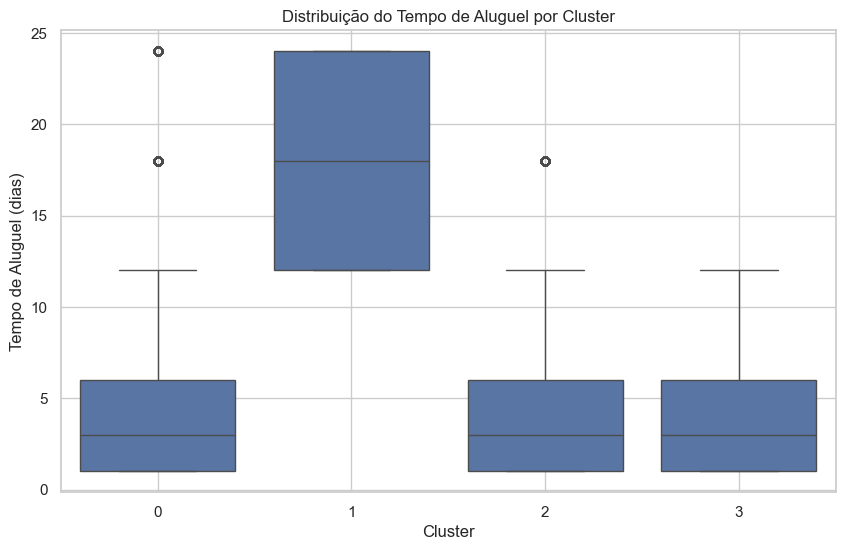

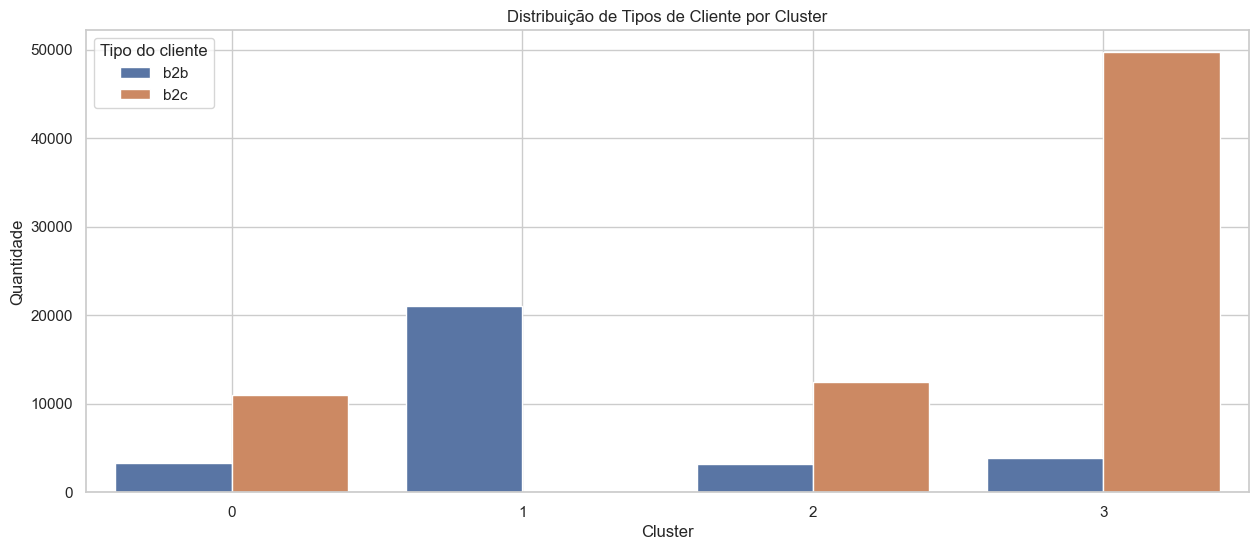

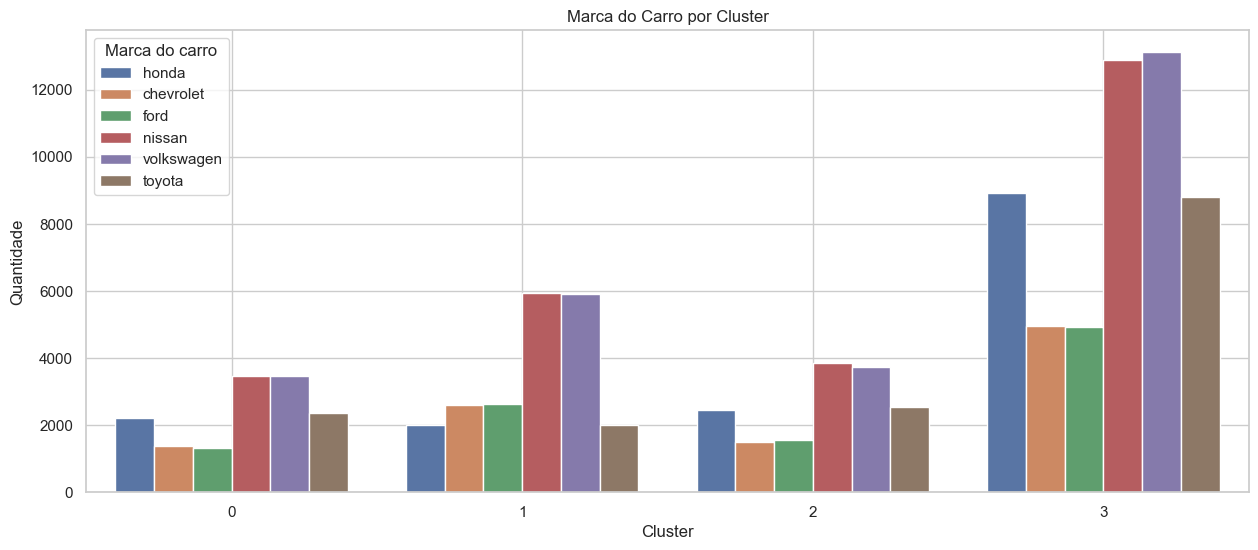

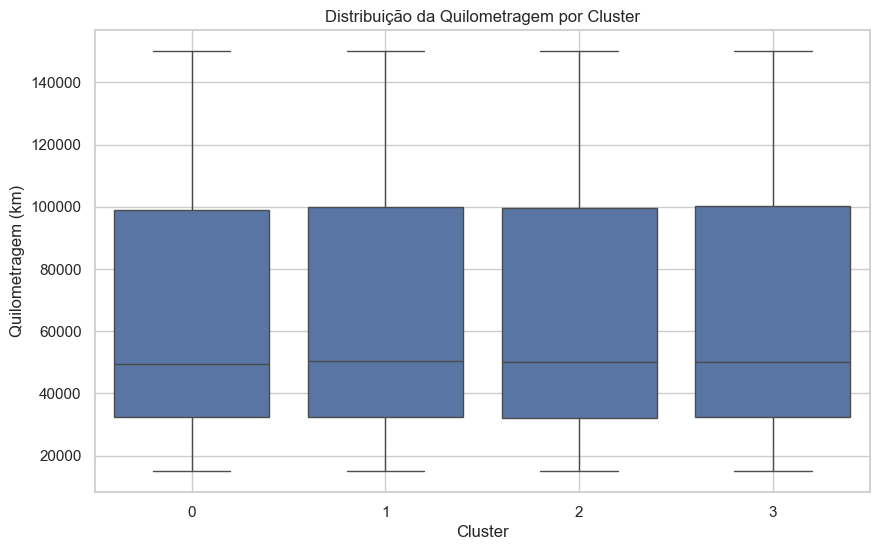

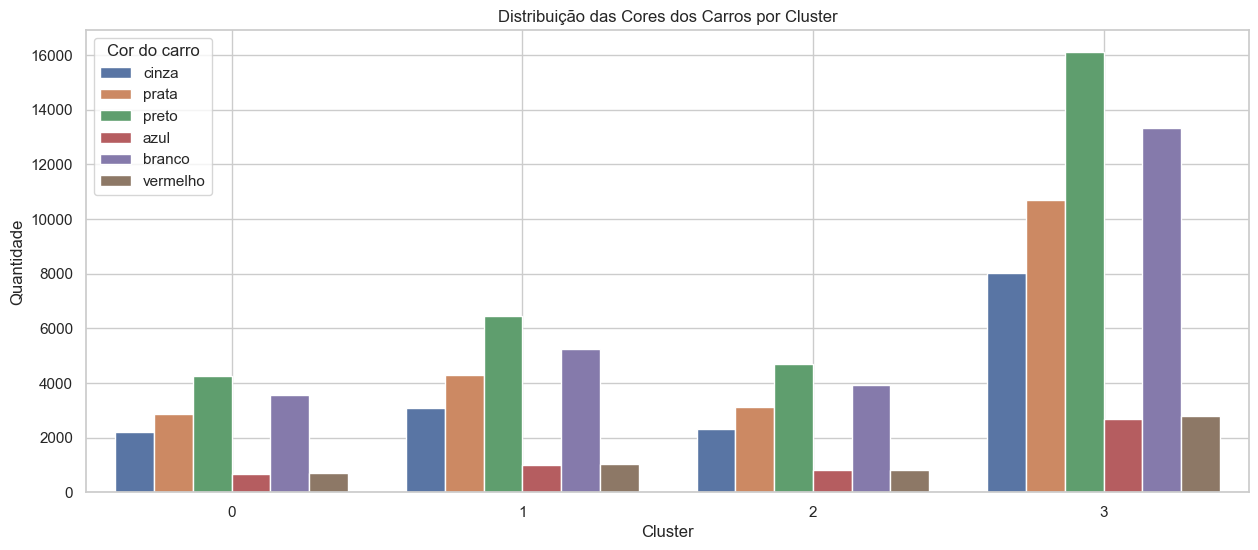

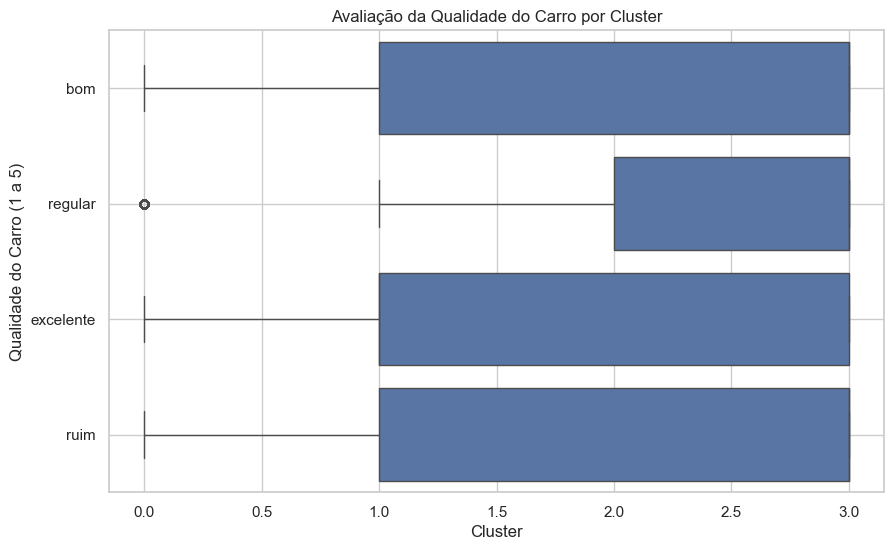

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar a base com a coluna cluster
#db_alterado_com_cluster = pd.read_csv('db_alterado_com_cluster.csv', encoding='utf-8')

# Definir estilo dos gráficos
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.countplot(data=db_final, x='cluster', hue='Qualidade do carro')
plt.title('Qualidade do Carro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Qualidade')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=db_final, x='cluster', hue='Idade do carro')
plt.title('Distribuição de Idade do carro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade')
plt.legend(title='Idade do Carro (anos)', loc='upper right')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Aumentar a legibilidade dos gráficos
sns.set(style="whitegrid")

# Gráfico 1: Contagem de Pagamentos Atrasados por Cluster
plt.figure(figsize=(15, 6))
sns.countplot(data=db_final, x='cluster', hue='Pagamentos atrasados')
plt.title('Pagamentos Atrasados por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

# Gráfico 2: Boxplot do Valor do Contrato do Aluguel por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=db_final, x='cluster', y='Valor do contrato do aluguel')
plt.title('Distribuição do Valor do Aluguel por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Valor do Contrato (R$)')
plt.grid(True)
plt.show()

# Gráfico 3: Boxplot do Tempo de Aluguel por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=db_final, x='cluster', y='Tempo de aluguel')
plt.title('Distribuição do Tempo de Aluguel por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Tempo de Aluguel (dias)')
plt.grid(True)
plt.show()

# Gráfico 4: Contagem de Clientes por Tipo e Cluster
plt.figure(figsize=(15, 6))
sns.countplot(data=db_final, x='cluster', hue='Tipo do cliente')
plt.title('Distribuição de Tipos de Cliente por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

# Gráfico 5: Contagem de Categorias de Carro por Cluster
plt.figure(figsize=(15, 6))
sns.countplot(data=db_final, x='cluster', hue='Marca do carro')
plt.title('Marca do Carro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

# Gráfico 6: Boxplot da Quilometragem do Carro por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=db_final, x='cluster', y='Quilometragem do carro')
plt.title('Distribuição da Quilometragem por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quilometragem (km)')
plt.grid(True)
plt.show()

# Gráfico 7: Contagem por Cor do Carro em Cada Cluster
plt.figure(figsize=(15, 6))
sns.countplot(data=db_final, x='cluster', hue='Cor do carro')
plt.title('Distribuição das Cores dos Carros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()

# Gráfico 8: Boxplot da Avaliação da Qualidade do Carro por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=db_final, x='cluster', y='Qualidade do carro')
plt.title('Avaliação da Qualidade do Carro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Qualidade do Carro (1 a 5)')
plt.grid(True)
plt.show()



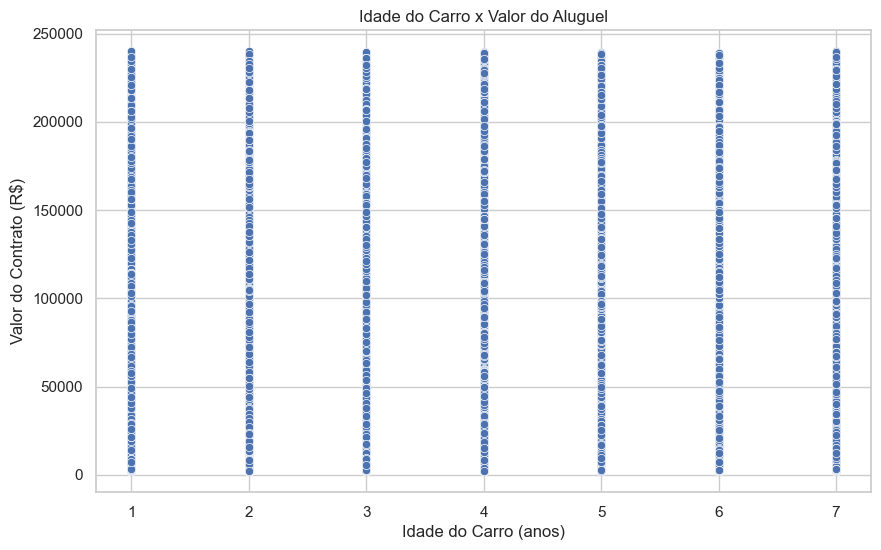

In [13]:
#gráfico fazendo uma correlação entre idade do veiculo e preco do aluguel, sem separar por cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=db_final, x='Idade do carro', y='Valor do contrato do aluguel')
plt.title('Idade do Carro x Valor do Aluguel')
plt.xlabel('Idade do Carro (anos)')
plt.ylabel('Valor do Contrato (R$)')
plt.grid(True)
plt.show()